<a href="https://colab.research.google.com/github/simonEllershaw/latent_variable_OOD/blob/main/transformer_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
! pip install pip transformers torch
# ! pip install -q kaggle

In [43]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [44]:
# ! kaggle datasets download tboyle10/medicaltranscriptions -p data/
# ! unzip data/clinc150_uci.zip -d data

In [45]:
import json
with open('/content/data/clinc150_uci/data_full.json') as f:
  data = json.load(f)

In [46]:
data.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [47]:
data['oos_train'][:10]

[['how much is an overdraft fee for bank', 'oos'],
 ['why are exponents preformed before multiplication in the order of operations',
  'oos'],
 ['what size wipers does this car take', 'oos'],
 ['where is the dipstick', 'oos'],
 ['how much is 1 share of aapl', 'oos'],
 ['how is glue made', 'oos'],
 ['any headlines from my area', 'oos'],
 ['what is the largest state in the us', 'oos'],
 ['what is the current market trend', 'oos'],
 ['what is the most popular airline', 'oos']]

In [48]:
ood_keys = [key for key in data.keys() if 'oos' in key]
data['oos'] = []
for key in ood_keys:
  data['oos'] += data.pop(key)

In [49]:
data['train'][:10]

[['what expression would i use to say i love you if i were an italian',
  'translate'],
 ["can you tell me how to say 'i do not speak much spanish', in spanish",
  'translate'],
 ["what is the equivalent of, 'life is good' in french", 'translate'],
 ["tell me how to say, 'it is a beautiful morning' in italian", 'translate'],
 ['if i were mongolian, how would i say that i am a tourist', 'translate'],
 ["how do i say 'hotel' in finnish", 'translate'],
 ["i need you to translate the sentence, 'we will be there soon' into portuguese",
  'translate'],
 ['please tell me how to ask for a taxi in french', 'translate'],
 ["can you tell me how i would say, 'more bread please' in french",
  'translate'],
 ["what is the correct way to say 'i am a visitor' in french", 'translate']]

In [50]:
data['oos'][:10]

[['set a warning for when my bank account starts running low', 'oos'],
 ['a show on broadway', 'oos'],
 ['who has the best record in the nfl', 'oos'],
 ['how do i find the area of a circle', 'oos'],
 ['how many onions do i have on hand', 'oos'],
 ['what is the name of the 13th president', 'oos'],
 ['show me recent activity in my backyard', 'oos'],
 ['how long will it take me to pay off my card if i pay an extra $50 a month over the minimum',
  'oos'],
 ['does our bank have free notary', 'oos'],
 ['what were the top stories this week', 'oos']]

In [60]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer)

In [54]:
from torch.utils.data import Dataset

class HuggingFaceDataset(Dataset):
  def __init__(self, label2id, tokenizer, texts, labels=None):
    self._dict = tokenizer(texts, truncation=True)
    if labels is not None:
      self._dict['labels'] = [label2id[label] for label in labels]

  def __len__(self):
        return len(self._dict["input_ids"])

  def __getitem__(self, idx):
      return {k: v[idx] for k, v in self._dict.items()}

label_names = sorted({label for _, label in data['train']})
id2label = dict(enumerate(sorted(label_names)))
label2id = {v: k for k, v in id2label.items()}

datasets_hf = {}
for key, dataset in data.items():
  texts, labels = map(list,zip(*dataset))
  if labels[0] == 'oos':
    labels = None
  datasets_hf[key] = HuggingFaceDataset(label2id, tokenizer, texts, labels) 

In [57]:
for key, dataset in datasets_hf.items():
  print(key, len(dataset))

val 3000
train 15000
test 4500
oos 1200


(array([1.013e+03, 4.410e+03, 6.366e+03, 2.022e+03, 7.220e+02, 3.610e+02,
        6.800e+01, 3.200e+01, 4.000e+00, 2.000e+00]),
 array([ 3. ,  6.4,  9.8, 13.2, 16.6, 20. , 23.4, 26.8, 30.2, 33.6, 37. ]),
 <a list of 10 Patch objects>)

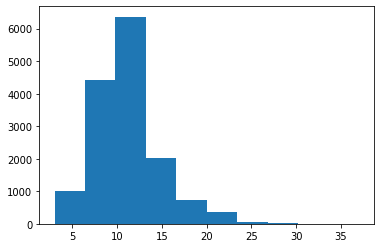

In [58]:
import matplotlib.pyplot as plt
plt.hist([len(sample['input_ids']) for sample in datasets_hf['train']])

In [59]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [62]:
from transformers import TrainingArguments

batch_size=32
args = TrainingArguments(
    "inscope_text_classification",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    group_by_length=True,
    warmup_ratio=0.1,
    load_best_model_at_end=True
)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
  """Called to compute validation metrics at each evaluation step of training."""
  logits, labels = eval_pred
  labels = labels.flatten()
  predictions = np.argmax(logits, axis=-1).flatten()

  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average='macro', zero_division=0
  )
  metrics = {"f1": f1, "precision": precision, "recall": recall}
  return metrics

In [ ]:
from transformers import Trainer, DataCollatorWithPadding, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=datasets_hf['train'],
    eval_dataset=datasets_hf['val'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4690
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: simon_ellershaw (use `wandb login --relogin` to force relogin)


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,3.507900,1.038306,0.903988,0.915600,0.907333
2,0.469100,0.221534,0.962404,0.965474,0.962667
3,0.108800,0.170812,0.965189,0.967871,0.965333
4,0.050000,0.182443,0.966577,0.969988,0.966333
5,0.033600,0.170132,0.971933,0.973894,0.972000
6,0.020400,0.163326,0.972200,0.974271,0.972333
7,0.014200,0.160175,0.973853,0.975546,0.974000
8,0.008700,0.167610,0.975209,0.977163,0.975333
9,0.006900,0.166190,0.975937,0.977739,0.976000
10,0.005000,0.167297,0.975598,0.977366,0.975667


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to inscope_text_classification/checkpoint-469
Configuration saved in inscope_text_classification/checkpoint-469/config.json
Model weights saved in inscope_text_classification/checkpoint-469/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to inscope_text_classification/checkpoint-938
Configuration saved in inscope_text_classification/checkpoint-938/config.json
Model weights saved in inscope_text_classification/checkpoint-938/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to inscope_text_classification/checkpoint-1407
Configuration saved in inscope_text_classification/checkpoint-1407/config.json
Model weights saved in inscope_text_classification/checkpoint-1407/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model chec

TrainOutput(global_step=4690, training_loss=0.42247336266645746, metrics={'train_runtime': 664.0677, 'train_samples_per_second': 225.881, 'train_steps_per_second': 7.063, 'total_flos': 883268415517824.0, 'train_loss': 0.42247336266645746, 'epoch': 10.0})

In [61]:
model = AutoModelForSequenceClassification.from_pretrained('/content/inscope_text_classification/checkpoint-3283')

In [63]:
import torch


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()
dataloader = torch.utils.data.DataLoader(
    datasets_hf['train'], batch_size=batch_size, collate_fn=data_collator
)

outputs = []
with torch.set_grad_enabled(False):
    for batch in dataloader:
        batch.pop("labels", default=None)
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs.append(model(**batch, output_hidden_states=True))

In [71]:
model.config

RobertaConfig {
  "_name_or_path": "/content/inscope_text_classification/checkpoint-3283",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "accept_reservations",
    "1": "account_blocked",
    "2": "alarm",
    "3": "application_status",
    "4": "apr",
    "5": "are_you_a_bot",
    "6": "balance",
    "7": "bill_balance",
    "8": "bill_due",
    "9": "book_flight",
    "10": "book_hotel",
    "11": "calculator",
    "12": "calendar",
    "13": "calendar_update",
    "14": "calories",
    "15": "cancel",
    "16": "cancel_reservation",
    "17": "car_rental",
    "18": "card_declined",
    "19": "carry_on",
    "20": "change_accent",
    "21": "change_ai_name",
    "22": "change_language",
    "23": "change_speed",
    "24": "change_user_name",
    "25": "cha

In [76]:
outputs[0]['hidden_states'][-1][:,0].size()

torch.Size([32, 768])

In [87]:
latent_states = torch.zeros(len(datasets_hf['train']), model.config.hidden_size)
for idx, output in zip(range(0, len(datasets_hf['train']), batch_size), outputs):
  latent_states[idx:idx+batch_size] = output['hidden_states'][-1][:,0]

In [90]:
latent_states.size()

torch.Size([15000, 768])